In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt

Constructing the Input Data

In [10]:
# Set-Up
# N_d: number of detectors; N_t: number of times data is detected by each detector; N_p: number of pixels
# signal: data of signal (which in this case is modeled to be a sine function in each pixel)
# P: pointing matrix

N_d, N_t, N_p = 3, 150 * 25, 25

signal = [[0] for _ in range(N_p)]
for i in range(N_p):
    signal[i][0] = 5 * i * math.sin((2 * math.pi / 25) * i)
signal = np.array(signal)[:,0]

P = [[0] * N_p for _ in range(N_t * N_d)]
for i in range(N_d):
    for row in range(N_t):
        for col in range(N_p):
            if ((row / 150) // 1 == col):
                P[i * N_t + row][col] = 1
P = np.array(P)

(25,)


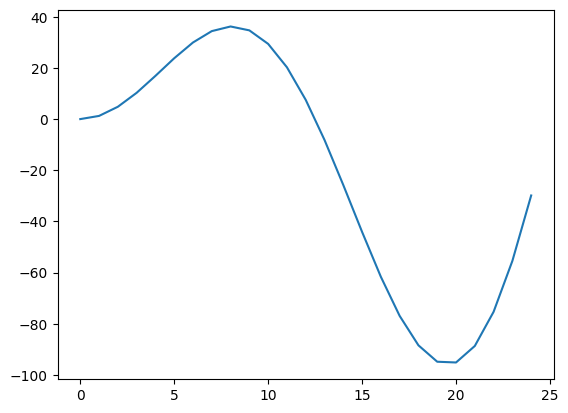

In [11]:
# check signal

print(np.shape(signal))
plt.plot(signal)

In [12]:
print(np.shape(P))

(11250, 25)


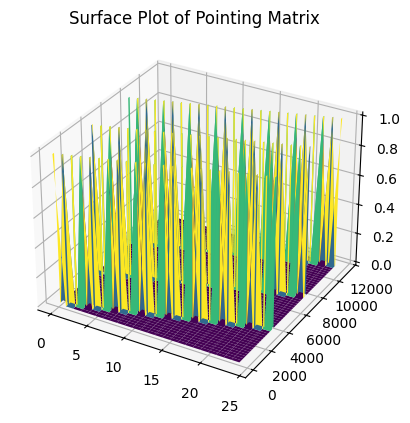

In [13]:
# check P

""" print(np.where(P[0] == 1))
print(np.where(P[150] == 1))
print(np.where(P[300] == 1))
print(np.where(P[301] == 1))
print(np.where(P[50 * 150 - 1] == 1))

print(np.where(P[0+N_t] == 1))
print(np.where(P[150+N_t] == 1))
print(np.where(P[300+N_t] == 1))
print(np.where(P[301+N_t] == 1))
print(np.where(P[50*150-1+N_t] == 1))

print(np.where(P[0+N_t*2] == 1))
print(np.where(P[150+N_t*2] == 1))
print(np.where(P[300+N_t*2] == 1))
print(np.where(P[301+N_t*2] == 1))
print(np.where(P[50*150-1+N_t*2] == 1)) """

from mpl_toolkits.mplot3d import Axes3D

x = np.arange(P.shape[1])
y = np.arange(P.shape[0])
x, y = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, P, cmap='viridis')
ax.set_title("Surface Plot of Pointing Matrix")
plt.show()

In [14]:
input = P @ signal
print(np.shape(input))

(11250,)


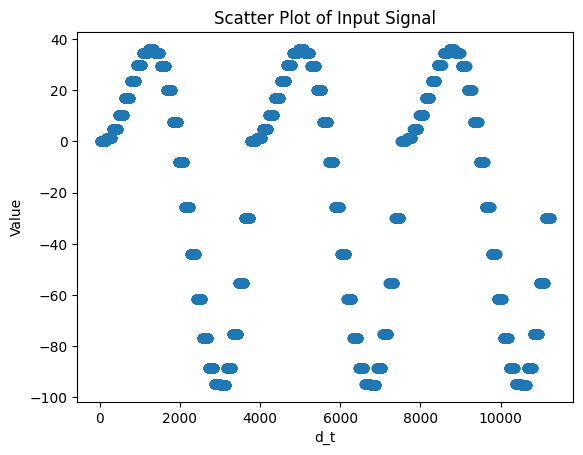

In [15]:
# Scatter Plot of Input Signal

plt.scatter(range(len(input)), input)
plt.xlabel("d_t")
plt.ylabel("Value")
plt.title("Scatter Plot of Input Signal")
plt.show()

Add White, Gaussian Noise to Data Stream

In [16]:
# Creating noisy data

N = N_t
noise_1 = np.random.randn(N) * 10
noise_2 = np.random.randn(N) * 10
noise_3 = np.random.randn(N) * 10

# Check the mean and variance
print(np.shape(noise_1))
print("Mean:", np.mean(noise_1))
print("Variance:", np.var(noise_1))

noise = np.concatenate([noise_1, noise_2, noise_3])
print(np.shape(noise))

Data = input + noise


(3750,)
Mean: -0.01741049726954302
Variance: 102.44486707647397
(11250,)


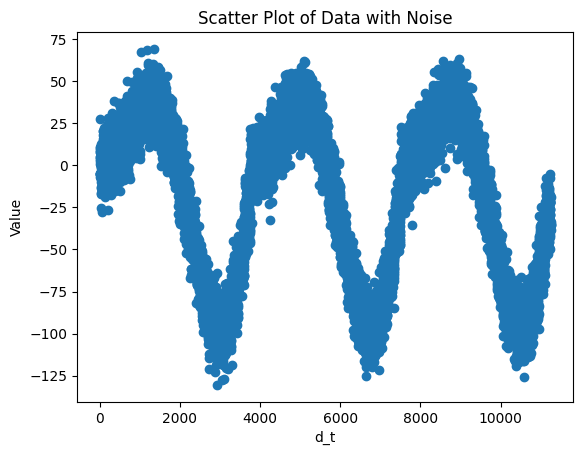

In [17]:
# Scatter Plot of Data

plt.scatter(range(len(Data)), Data)
plt.xlabel("d_t")
plt.ylabel("Value")
plt.title("Scatter Plot of Data with Noise")
plt.show()

Text(0.5, 1.0, 'Regular Plot of Data with Noise')

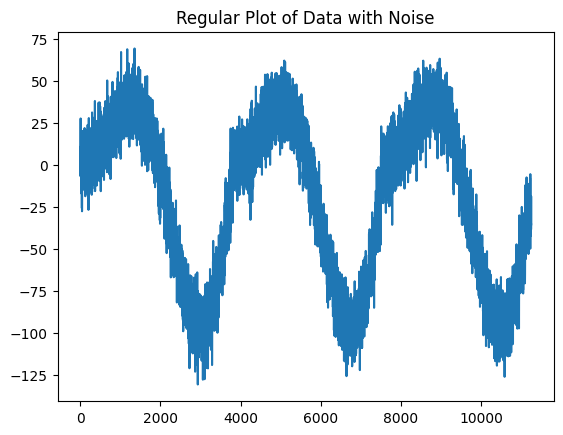

In [18]:

plt.plot(Data)
plt.title("Regular Plot of Data with Noise")

Extracting Signal from the Data when Noise is White

In [19]:
# Covariance matrix set to N_t-th identity matrix

cov_inv = (1 / np.var(noise)) * np.eye(N_t*N_d)

In [20]:
# esitmation of signal

intermediate = P.T @ cov_inv

signal_est = np.linalg.inv(intermediate @ P) @ (intermediate @ Data)

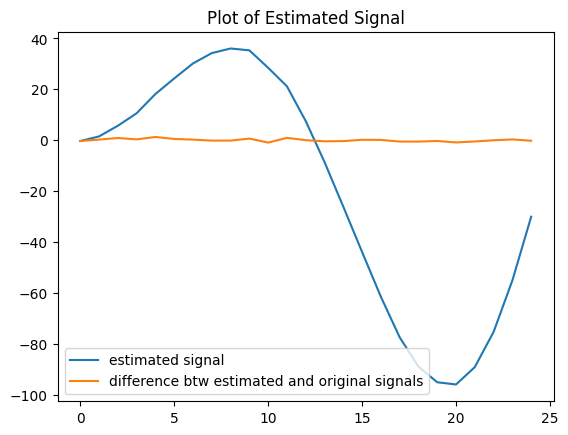

In [21]:
# Compare estimates signal with original signal

plt.plot(signal_est, label = "estimated signal")
comp = signal_est - signal
plt.plot(comp, label = "difference btw estimated and original signals")
plt.title("Plot of Estimated Signal")
plt.legend()

Text(0.5, 1.0, 'Difference btw Estimated and Original Signals')

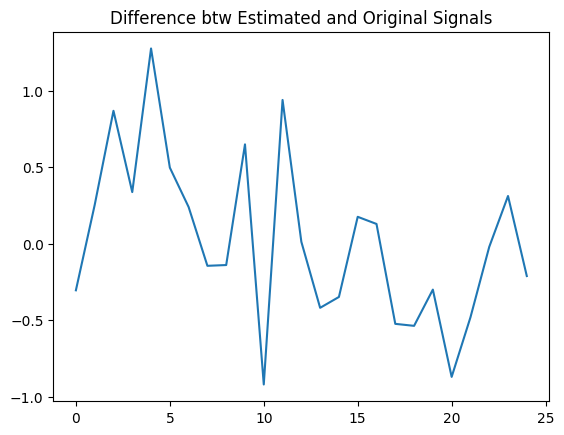

In [22]:
comp = signal_est - signal
plt.plot(comp)
plt.title("Difference btw Estimated and Original Signals")

Field level estimation

In [23]:
import numpyro 
import math
import jax 
import jax.numpy as jnp 
import jax.random as jr 
import numpy as np 
import matplotlib.pyplot as plt 

from jax import random
from numpyro.infer import MCMC, NUTS

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
import numpyro.distributions as dist

def model_func():
        s = numpyro.sample("s", dist.Uniform(low=jnp.full(25,-150), high=jnp.full(25,50)))
        d = P @ s
        print(d.shape)
        d_noised = numpyro.sample("d_noised", dist.Normal(d,10.), obs=Data)
        return d_noised

rng_key = random.PRNGKey(0)
nuts_kernel = NUTS(model_func)
mcmc = MCMC(nuts_kernel, num_warmup=100, num_samples=100)
mcmc.run(rng_key)

(11250,)
(11250,)
(11250,)


  0%|          | 0/200 [00:00<?, ?it/s]

(11250,)
(11250,)


sample: 100%|██████████| 200/200 [00:00<00:00, 417.06it/s, 7 steps of size 4.42e-01. acc. prob=0.88]


In [25]:
import arviz as az
trace = az.from_numpyro(mcmc)

(11250,)
(11250,)


In [26]:
trace.posterior['s'].squeeze().shape

(100, 25)

/var/folders/0b/tq5hs3nd30zcmpv164dvt6rc0000gn/T/ipykernel_6279/1080638717.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


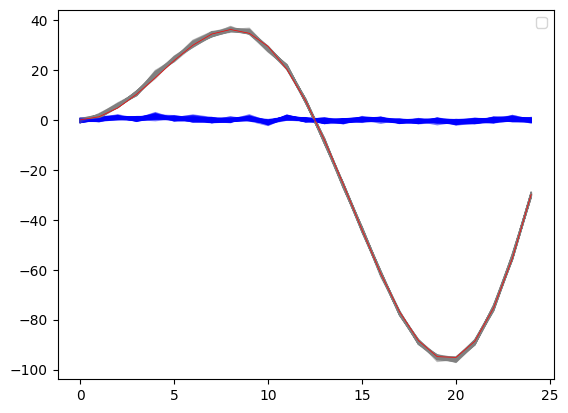

In [27]:
for i in range(100):
    plt.plot(trace.posterior['s'].squeeze()[i,:], color='gray', alpha=0.5, lw=1.0)
    plt.plot(trace.posterior['s'].squeeze()[i,:]-signal, color='blue', alpha=0.5, lw=1.0)
plt.plot(signal, color='red', lw=0.5)
plt.legend()
plt.show()

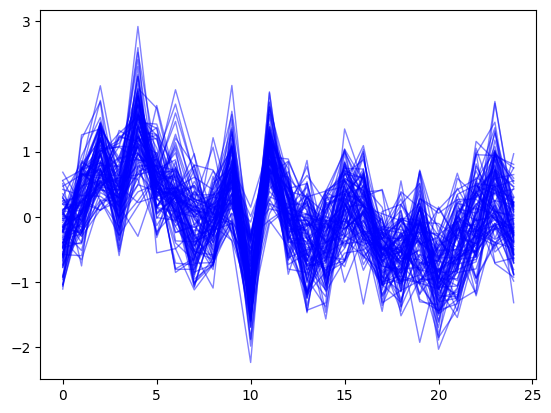

In [28]:
for i in range(100):
    plt.plot(trace.posterior['s'].squeeze()[i,:]-signal, color='blue', alpha=0.5, lw=1.0)

1.243449435824274


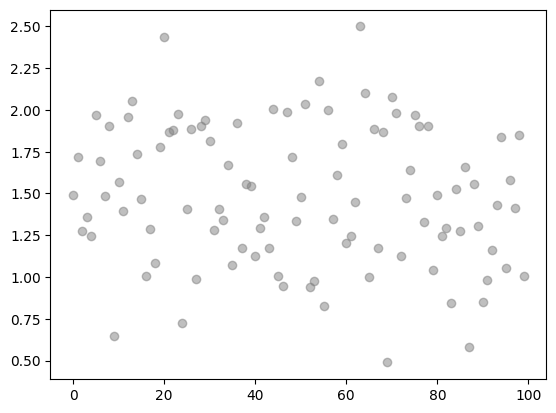

In [29]:
plt.scatter(range(100),trace.posterior['s'].squeeze()[:,1], color='gray', alpha=0.5, lw=1.0)
print(signal[1])

With the detectors not exactly aligning (exaggerated case)

In [82]:
# the detectors are 20 degrees apart, 
# we take the first detector as reference, 
# the second 20 degrees behind, 
# and the third 40 degreeds behind.

In [80]:
# adjusting the pointing matrix

P_2 = [[0] * N_p for _ in range(N_t * N_d)]
for i in range(N_d):
    for row in range(N_t):
        for col in range(N_p):
            if ((row/150)//1 == col):
                if (col+i*10 < N_p):
                    P_2[i*N_t+row][col+i*10] = 1
                else: 
                    P_2[i*N_t+row][(col+i*10)-N_p] = 1
            
P_2 = np.array(P_2)

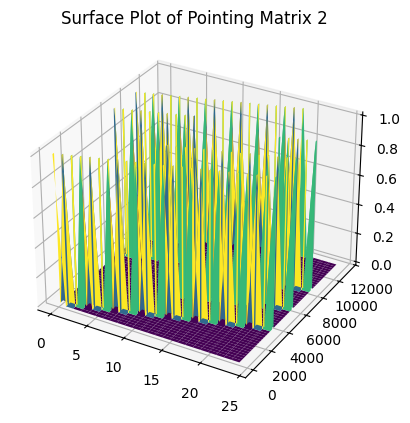

In [81]:
# check P_2

from mpl_toolkits.mplot3d import Axes3D

x = np.arange(P_2.shape[1])
y = np.arange(P_2.shape[0])
x, y = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, P_2, cmap='viridis')
ax.set_title("Surface Plot of Pointing Matrix 2")
plt.show()

In [83]:
# data

input_2 = P_2 @ signal
print(np.shape(input_2))

Data_2 = input_2 + noise

(11250,)


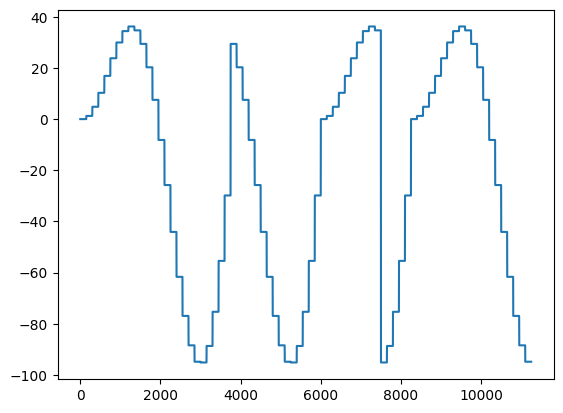

In [84]:
plt.plot(input_2)

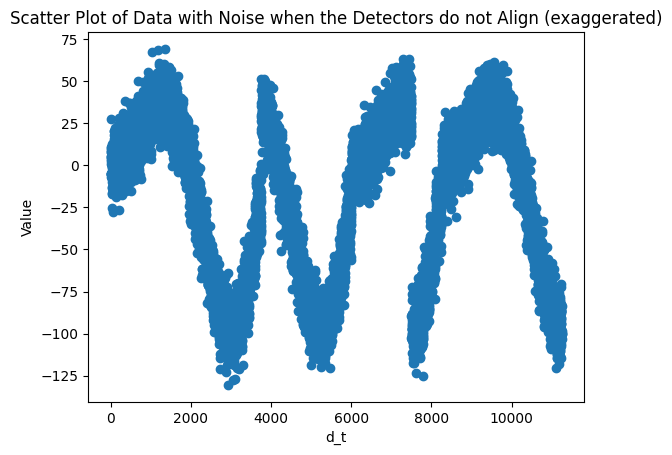

In [85]:
# Scatter Plot of Data

plt.scatter(range(len(Data_2)), Data_2)
plt.xlabel("d_t")
plt.ylabel("Value")
plt.title("Scatter Plot of Data with Noise when the Detectors do not Align (exaggerated)")
plt.show()

In [86]:
def model_func_2():
        s = numpyro.sample("s", dist.Uniform(low=jnp.full(25,-150), high=jnp.full(25,50)))
        d = P_2 @ s
        print(d.shape)
        d_noised = numpyro.sample("d_noised", dist.Normal(d,10.), obs=Data_2)
        return d_noised

# rng_key = random.PRNGKey(0)
nuts_kernel_2 = NUTS(model_func_2)
mcmc_2 = MCMC(nuts_kernel_2, num_warmup=100, num_samples=100)
mcmc_2.run(rng_key)

(11250,)
(11250,)
(11250,)


  0%|          | 0/200 [00:00<?, ?it/s]

(11250,)
(11250,)


sample: 100%|██████████| 200/200 [00:00<00:00, 373.89it/s, 7 steps of size 5.24e-01. acc. prob=0.84]


In [87]:
trace_2 = az.from_numpyro(mcmc_2)

(11250,)
(11250,)


In [88]:
trace_2.posterior['s'].squeeze().shape

(100, 25)

/var/folders/0b/tq5hs3nd30zcmpv164dvt6rc0000gn/T/ipykernel_6279/3992487635.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


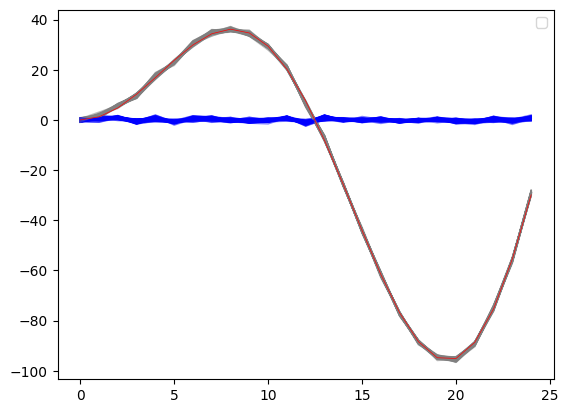

In [89]:
for i in range(100):
    plt.plot(trace_2.posterior['s'].squeeze()[i,:], color='gray', alpha=0.5, lw=1.0)
    plt.plot(trace_2.posterior['s'].squeeze()[i,:]-signal, color='blue', alpha=0.5, lw=1.0)
plt.plot(signal, color='red', lw=0.5)
plt.legend()
plt.show()

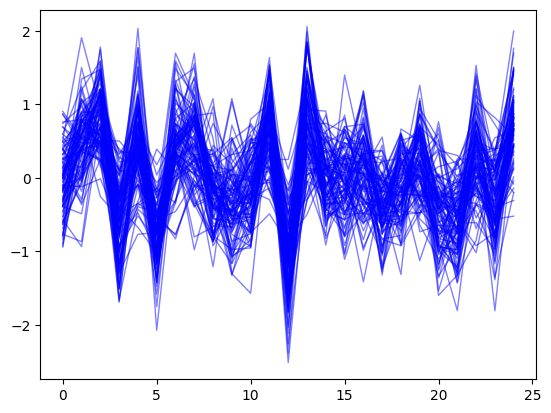

In [90]:
for i in range(100):
    plt.plot(trace_2.posterior['s'].squeeze()[i,:]-signal, color='blue', alpha=0.5, lw=1.0)

With the detectors not exactly aligning (more realistic case)

In [ ]:
# the detectors are 1/3 degrees apart, 
# we take the first detector as reference, 
# the second 1/3 degrees behind, 
# and the third 2/3 degrees behind.

In [71]:
# adjusting the pointing matrix
# 1/3 degrees apart -> 1/6 (i.e., 25/150) seconds apart (detectors move with 2 degrees per second)

P_3 = [[0] * N_p for _ in range(N_t * N_d)]
for i in range(N_d):
    for row in range(N_t):
        for col in range(N_p):
            if (row / 150) // 1 == col:
                if (row+i*25 < N_t):
                    P_3[i*N_t+row+i*25][col] = 1
                else:
                    P_3[i*N_t+(row+i*25-N_t)][col] = 1
            
P_3 = np.array(P_3)

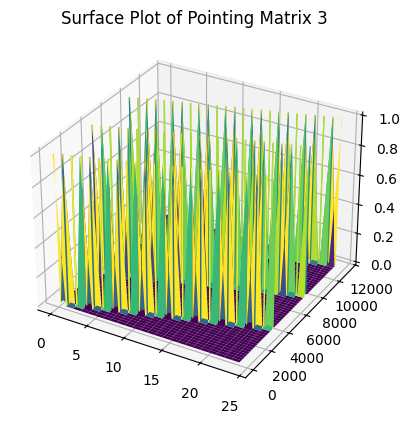

In [72]:
# check P_3

x = np.arange(P_3.shape[1])
y = np.arange(P_3.shape[0])
x, y = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, P_3, cmap='viridis')
ax.set_title("Surface Plot of Pointing Matrix 3")
plt.show()

In [73]:
# data

input_3 = P_3 @ signal
print(np.shape(input_3))

Data_3 = input_3 + noise

(11250,)


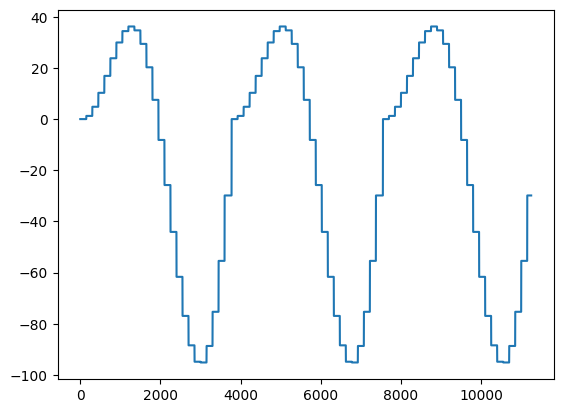

In [74]:
plt.plot(input_3)

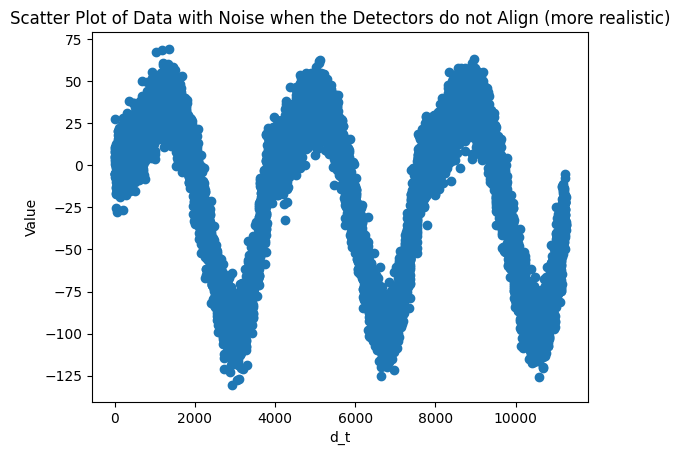

In [75]:
# Scatter Plot of Data

plt.scatter(range(len(Data_3)), Data_3)
plt.xlabel("d_t")
plt.ylabel("Value")
plt.title("Scatter Plot of Data with Noise when the Detectors do not Align (more realistic)")
plt.show()

In [76]:
def model_func_3():
        s = numpyro.sample("s", dist.Uniform(low=jnp.full(25,-150), high=jnp.full(25,50)))
        d = P_3 @ s
        print(d.shape)
        d_noised = numpyro.sample("d_noised", dist.Normal(d,10.), obs=Data_3)
        return d_noised

# rng_key = random.PRNGKey(0)
nuts_kernel_3 = NUTS(model_func_3)
mcmc_3 = MCMC(nuts_kernel_3, num_warmup=100, num_samples=100)
mcmc_3.run(rng_key)

(11250,)
(11250,)
(11250,)


  0%|          | 0/200 [00:00<?, ?it/s]

(11250,)
(11250,)


sample: 100%|██████████| 200/200 [00:00<00:00, 394.68it/s, 7 steps of size 4.79e-01. acc. prob=0.86]


In [77]:
trace_3 = az.from_numpyro(mcmc_3)
trace_3.posterior['s'].squeeze().shape

(11250,)
(11250,)


(100, 25)

/var/folders/0b/tq5hs3nd30zcmpv164dvt6rc0000gn/T/ipykernel_6279/2364232803.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


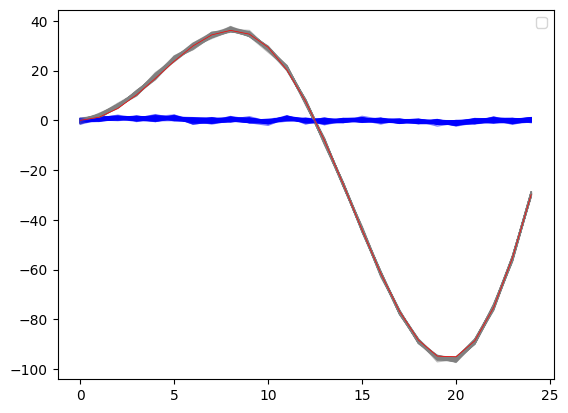

In [78]:
for i in range(100):
    plt.plot(trace_3.posterior['s'].squeeze()[i,:], color='gray', alpha=0.5, lw=1.0)
    plt.plot(trace_3.posterior['s'].squeeze()[i,:]-signal, color='blue', alpha=0.5, lw=1.0)
plt.plot(signal, color='red', lw=0.5)
plt.legend()
plt.show()

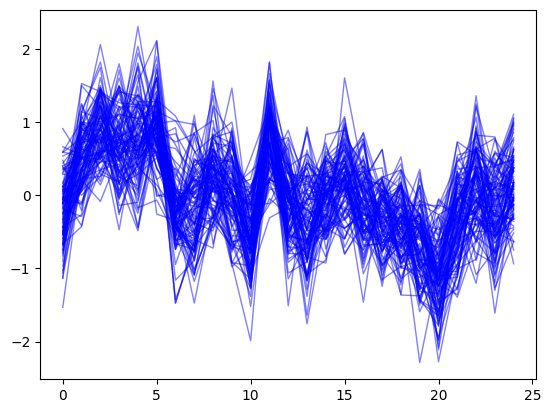

In [79]:
for i in range(100):
    plt.plot(trace_3.posterior['s'].squeeze()[i,:]-signal, color='blue', alpha=0.5, lw=1.0)